# Estimate the explosion time from a spectral time series #

Import modules

In [1]:
import sncosmo
import numpy as np
import os
import pickle
from astropy.table import Table
import matplotlib.pyplot as plt

from estimate_explosion_time.core.data_prep.data import DataHandler
from estimate_explosion_time.analyses.rappid_simulations import rappidDH
from estimate_explosion_time.shared import bandcolors

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Specify the path to the SED time series. In this case it's one of the templates from experimental data and think of some value for the redshift and the peak MJD.

In [2]:
my_source_path = 'data/SEDs/MODEL03/SDSS-014492.SED.gz'
redshift = 0
peak_mjd = 5551378

load the SED time series into sncosmo

In [3]:
def sncosmo_source(source_path):
    sed = Table(np.loadtxt(source_path), names=['phase', 'wl', 'flux'])
    phase = np.unique(sed['phase'])
    disp = np.unique(sed['wl'])
    flux = sed['flux'].reshape(len(phase), len(disp))
    snc_source = sncosmo.TimeSeriesSource(phase, disp, flux, zero_before=True)
    return snc_source

In [4]:
source = sncosmo_source(my_source_path)

## Asuming the peak time refers to the bolometric peak, construct a completly transparant bandpass to calculate the bolometric flux. ##

In [5]:
wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')

As the absolut amplitude of the flux doesn't matter, set it to an arbitrary value.

In [6]:
amp = 1e-1
source.set(amplitude=amp)

In order to draw the lightcurve, make a time array and calculate the bolometric flux for each step. Normalize the flux to the maximum.

In [7]:
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(complete_band, time)
flux = flux / max(flux)

Draw the lightcurve

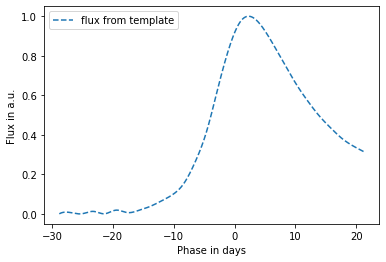

In [8]:
fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

Create a sncosmo Model in order to be able to set the redshift

In [9]:
model = sncosmo.Model(source)

Set the redshift and the time parameter $t_0$, that fixes the lightcurve on the time axis. Construct a new bandpass and get the flux, analog to before.

In [10]:
model.set(z=redshift)
complete_band = sncosmo.Bandpass(
    [model.minwave(), model.maxwave()], 
    [1, 1], name='complete band redshifted'
)
redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(complete_band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)

Shift the time axis so that the maximum flux is at peak MJD

In [11]:
redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd

Find the explosion time as the phase where the flux exceeds the rather arbitrary value $F_{threshold} = 0.001$

In [12]:
t_exp = min(redtime[redshifted_flux > 0.01])

Plot the result

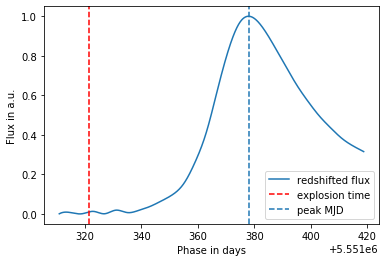

In [13]:
fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux')
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

## Repeat with different parameters and a different time series, this time from MOSFiT. ##

In [14]:
my_source_path = 'data/SEDs/MODEL13/ibc_176.dat.gz'
# redshift = 0.9
peak_mjd = 5551378

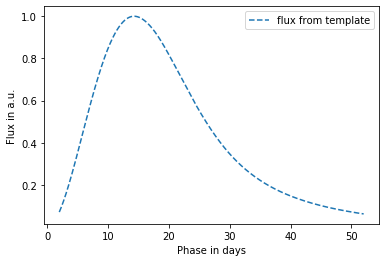

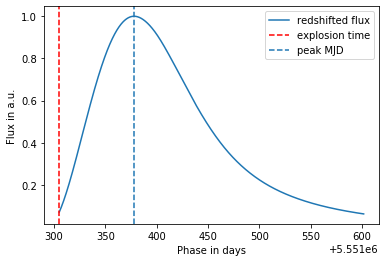

In [15]:
source = sncosmo_source(my_source_path)

wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')
amp = 1e-1
source.set(amplitude=amp)
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(complete_band, time)
flux = flux / max(flux)

fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

model = sncosmo.Model(source)
model.set(z=redshift)
complete_band = sncosmo.Bandpass(
    [model.minwave(), model.maxwave()], 
    [1, 1], name='complete band redshifted'
)
redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(complete_band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)
redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd
t_exp = min(redtime[redshifted_flux > 0.01])

fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux')
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

Apparently some templates are generated from theroetical models and don't include the explosion time. But the explosion time in the original template is at $t=0$!
So in the case where the original template starts at a phase $t_{start} > 0$, for each explosion time estimation account for this difference in the observer frame: 
$$ t_{exp} = t_{exp, pre} - t_{start} \cdot (1+z) $$

start of data: 2.004 
relative to the entire data length 0.04008


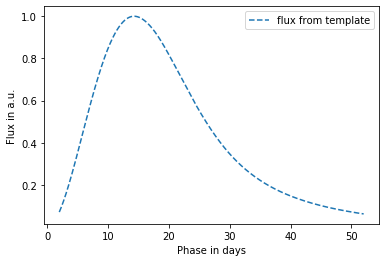

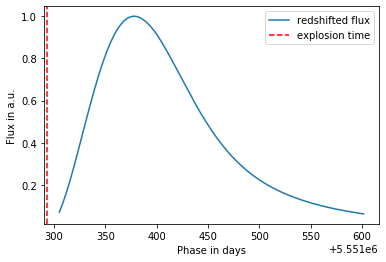

In [16]:
source = sncosmo_source(my_source_path)

wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')
amp = 1e-1
source.set(amplitude=amp)
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(complete_band, time)
flux = flux / max(flux)
tstart = min(time[flux > 0.01])
tstart_rel = tstart / (max(time)-min(time))
print('start of data:', tstart, '\nrelative to the entire data length', tstart_rel)

fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

model = sncosmo.Model(source)
model.set(z=redshift)
complete_band = sncosmo.Bandpass(
    [model.minwave(), model.maxwave()], 
    [1, 1], name='complete band redshifted'
)
redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(complete_band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)
redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd
t_exp_pre = min(redtime[redshifted_flux > 0.01])
t_exp = t_exp_pre - tstart_rel * (max(redtime)-min(redtime)) * (1 + redshift) if tstart > 0 else t_exp_pre

fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux')
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
# ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

## If peak MJD refers to peak in different band ##

start of data: 2.004 
relative to the entire data length 0.04008


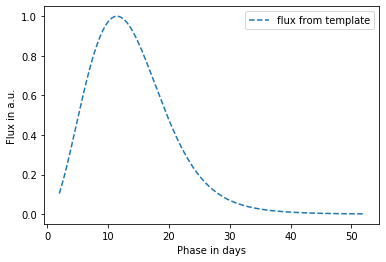

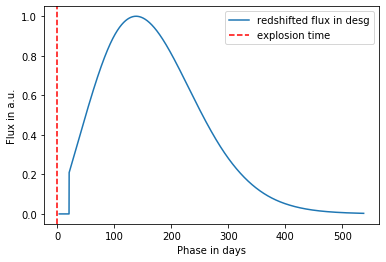

In [17]:
bandname = 'desg'

source = sncosmo_source(my_source_path)

wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
band = sncosmo.get_bandpass(bandname)
amp = 1e-1
source.set(amplitude=amp)
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(band, time)
flux = flux / max(flux)
tstart = min(time[flux > 0.01])
tstart_rel = tstart / (max(time)-min(time))
print('start of data:', tstart, '\nrelative to the entire data length', tstart_rel)

fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

model = sncosmo.Model(source)
model.set(z=0.8, t0=0)

redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)
# redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd
t_exp_pre = min(redtime[redshifted_flux > 0.01])
t_exp = t_exp_pre - tstart_rel * (max(redtime)-min(redtime)) * (1 + redshift) if tstart > 0 else t_exp_pre

fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux in ' + bandname)
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
# ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

## Make it all into one function ##

In [18]:
def get_explosion_time_from_template(template, band=None, peak_mjd=None, rredshift=0,
                                     steps=5000, flux_threshold=0.01, full_output=False):
    
    # initialize SNCosmo Source from path or from built-in SNCosmo Source
    source = sncosmo_source(template) if '/' in template else sncosmo.get_source(template)

    # construct bandpass
    # Use a completely transparent bandpass if no band is given
    transmission = [1, 1]
    if not band:
        src_wavelength = [source.minwave(), source.maxwave()]
        src_bandpass = sncosmo.Bandpass(src_wavelength, transmission, name='complete band')
    else:
        src_bandpass = sncosmo.get_bandpass(band)
    
    # set arbitrary amplitude
    amp = 1e-1
    source.set(amplitude=amp)
    
    # get time and flux, normalize the flux
    time = np.linspace(source.minphase(), source.minphase()+50, steps) 
    flux = source.bandflux(src_bandpass, time)
    flux = flux / max(flux)
    
    # get the explosion time as phase when flux crosses flux threshold
    # as this is done without any redshift involved this refers to the restframe
    tstart = min(time[flux > flux_threshold])
    print('template starts at ' + str(tstart))
    tstart_rel = tstart / (max(time)-min(time))
    print('relative to the whole template time that\'s ' + str(tstart_rel))

    # initialize SNCosmo Model in order to set the redshift
    # this now refers to the observer frame
    model = sncosmo.Model(source=source)
    t = 0
    print('setting t0 to ' + str(t))
    print('setting redshift to ' + str(rredshift))
    model.set(z=rredshift, t0=t)
    
    # as the redshift shifts the spectral range it's necesarry to make a new complete bandpass for the shifted model
    if not band:
        mdl_wavelength = [model.minwave(), model.maxwave()]
        mdl_bandpass = sncosmo.Bandpass(mdl_wavelength, transmission, name='complete band')
    else:
        mdl_bandpass = sncosmo.get_bandpass(band)
        

    # get the time array and flux in the observer frame
    redtime = np.linspace(model.mintime(), model.maxtime(), steps)
    redshifted_flux = model.bandflux(mdl_bandpass, redtime)
    redshifted_flux = redshifted_flux / max(redshifted_flux)
    
    # shift the time array so the maximum flux is at peak MJD
    if peak_mjd:
        print('shift time array')
        redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd
    
    # determine explosion time
    t_exp_pre = min(redtime[redshifted_flux > 0.01])
    
    # if explosion time in template was after t=0 assume it is a theoretical model and that t=0 is the explosion time
    # IS THIS VALID ?!?!?!?!
    t_exp = t_exp_pre - tstart_rel * (max(redtime)-min(redtime)) * (1 + rredshift) if tstart > 0 else t_exp_pre
    
    if full_output:
        return t_exp, redtime, redshifted_flux
    else:
        return t_exp

Done in Code here:

In [19]:
from estimate_explosion_time.core.analyse_fits_from_simulation.get_source_explosion_time.find_explosion_time \
import get_explosion_time

## Test with simulations where texplosion is known ##
try to change the band and see how the explosion time estimation changes

In [20]:
simsurveyDH = DataHandler.get_dhandler('simsurvey_simulation')
path = simsurveyDH.get_data('sncosmo')
ind = 67
with open(path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

band = None
lc = data['lcs'][ind]
plot_lc = lc if not band else lc[lc['band'] == band]
texp_true = data['meta']['t0'][ind]
this_redshift = data['meta']['z'][ind]
amplitude = data['meta']['amplitude'][ind]
simulated_with = 'nugent-sn1bc'

texp_true: 2458487.7520937384
redshift: 0.13040458937030827
template starts at 0.0600120024004801
relative to the whole template time that's 0.0012002400480096021
setting redshift to 0.13040458937030827
shift time array


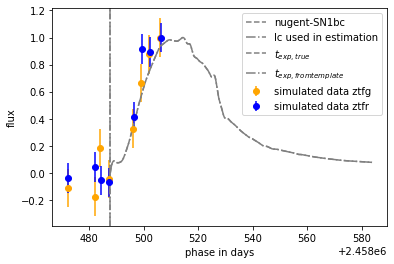

difference: 0.053480266593396664


In [21]:
model = sncosmo.Model(source=simulated_with)
print('texp_true: ' + str(texp_true))
print('redshift: ' + str(this_redshift))

model.set(t0=texp_true, z=this_redshift, amplitude=amplitude)

wavelength = [model.minwave(), model.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')

time = np.linspace(model.mintime(), model.maxtime(), 5000)
flux = model.bandflux(complete_band if not band else band, time)
flux = flux/max(flux)

peak_mjd = time[np.argmax(flux)]

texp_from_template, t, f = get_explosion_time(simulated_with, 
                                                band=band, 
                                                peak_mjd=peak_mjd, 
                                                redshift=this_redshift,
                                                full_output=True)

fig, ax = plt.subplots()
color=bandcolors(band)
ax.plot(time, flux, label='nugent-SN1bc', color=color, ls='--')
ax.plot(t, f, label='lc used in estimation', color=color, ls='-.')

for plot_band in np.unique(plot_lc['band']):
    band_lc = plot_lc[plot_lc['band'] == plot_band]
    ax.errorbar(band_lc['time'], band_lc['flux']/max(band_lc['flux']), 
                yerr=band_lc['fluxerr']/max(band_lc['flux']), 
                color=bandcolors(plot_band), ls='', marker='o', label='simulated data ' + plot_band)

ax.axvline(texp_true, ls='--', color=color, label=r'$t_{exp,true}$')
ax.axvline(texp_from_template, ls='-.', color=color, label=r'$t_{exp,from template}$')


ax.set_xlabel('phase in days')
ax.set_ylabel('flux')
if band:
    ax.set_title("flux in " + band)
ax.legend()

plt.show()
plt.close()

print('difference: ' + str(texp_true - texp_from_template))

## Test with a simulation, where only the peak date is known ##

In [22]:
generated_with = 'mosfit'
thisDH = rappidDH.get_dhandler(generated_with)
with open(thisDH.get_data('sncosmo'), 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    
ind = 835

band = None
lc = data['lcs'][ind]
plot_lc = lc if not band else lc[lc['band'] == band]
peak_mjd = data['meta']['t_peak'][ind]
this_redshift = data['meta']['z'][ind]
peak_band = lc['band'][lc['time'] == peak_mjd]

print('redshift: ' + str(this_redshift))
print('peak MJD: ' + str(peak_mjd))
print('peak band: ' + str(peak_band))

redshift: 0.12337586
peak MJD: 57573.625
peak band: band
----


template starts at 2.004
relative to the whole template time that's 0.04008
setting redshift to 0.12337586
shift time array
48.92670211345103


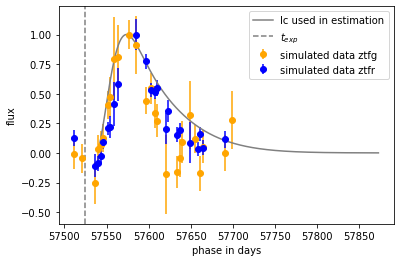

In [26]:
source = sncosmo_source(thisDH.get_spectral_time_evolution_file(ind))


model = sncosmo.Model(source=source)
model.set(t0=texp_true, z=this_redshift, amplitude=1e-12)

wavelength = [model.minwave(), model.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')

time = np.linspace(model.mintime(), model.maxtime(), 5000)
flux = model.bandflux(complete_band if not band else band, time)
flux = flux/max(flux)

# shift time so the peak is at peak time
time = time - time[np.argmax(flux)] + peak_mjd

texp_from_template, t, f = get_explosion_time(thisDH.get_spectral_time_evolution_file(ind), 
                                                            band=band, 
                                                            peak_mjd=peak_mjd, 
                                                            redshift=this_redshift,
                                                            full_output=True)

print(peak_mjd - texp_from_template)

fig, ax = plt.subplots()

ax.plot(t, f, bandcolors(band), label='lc used in estimation')

for plot_band in np.unique(plot_lc['band']):
    band_lc = plot_lc[plot_lc['band'] == plot_band]
    ax.errorbar(band_lc['time'], band_lc['flux']/max(band_lc['flux']), 
                yerr=band_lc['fluxerr']/max(band_lc['flux']), 
                color=bandcolors(plot_band), ls='', marker='o', label='simulated data ' + plot_band)
    
ax.axvline(texp_from_template, ls='--', color=bandcolors(band), label=r'$t_{exp}$')


ax.set_xlabel('phase in days')
ax.set_ylabel('flux')
if band:
    ax.set_title("flux in " + band)
ax.legend()

plt.show()
plt.close()